In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/drcatgradcamfull/cat_ren/Mild/f481f76a6b75.png
/kaggle/input/drcatgradcamfull/cat_ren/Mild/abdb365cacbc.png
/kaggle/input/drcatgradcamfull/cat_ren/Mild/33ffddea8c6e.png
/kaggle/input/drcatgradcamfull/cat_ren/Mild/059bc89df7f4.png
/kaggle/input/drcatgradcamfull/cat_ren/Mild/278aa860dffd.png
/kaggle/input/drcatgradcamfull/cat_ren/Mild/d66b6f333dc7.png
/kaggle/input/drcatgradcamfull/cat_ren/Mild/a8c950a99107.png
/kaggle/input/drcatgradcamfull/cat_ren/Mild/cab3dfa7962d.png
/kaggle/input/drcatgradcamfull/cat_ren/Mild/63363410389a.png
/kaggle/input/drcatgradcamfull/cat_ren/Mild/4da2961e62fe.png
/kaggle/input/drcatgradcamfull/cat_ren/Mild/22098b1fe461.png
/kaggle/input/drcatgradcamfull/cat_ren/Mild/e9286ddf6ffe.png
/kaggle/input/drcatgradcamfull/cat_ren/Mild/4c129470cec4.png
/kaggle/input/drcatgradcamfull/cat_ren/Mild/6b07971c3bf6.png
/kaggle/input/drcatgradcamfull/cat_ren/Mild/b1197f2cc9b3.png
/kaggle/input/drcatgradcamfull/cat_ren/Mild/90c982cc2d96.png
/kaggle/input/drcatgradc

In [2]:
import copy
import warnings
warnings.filterwarnings('ignore')

import cv2
import keras
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, Input
from keras.layers import Conv2D, Activation, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
#from keras.applications.resnet50 import preprocess_input, ResNet50
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
import shap
import tensorflow
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical


In [3]:
W = 112 # The default size for ResNet is 224 but resize to .5 to save memory size
H = 112 # The default size for ResNet is 224 but resize to .5 to save memory size
label_to_class = {
    'Nodr': 0,
    'Mild': 1,
    'Moderate':2,
    'Severe': 3,
    'Proliferative': 4,
   
}
class_to_label = {v: k for k, v in label_to_class.items()}
n_classes = len(label_to_class)

def get_images(dir_name='../input/drcatgradcamfull/cat_ren', label_to_class=label_to_class):
    """read images / labels from directory"""
    
    Images = []
    Classes = []
    
    for label_name in os.listdir(dir_name):
        cls = label_to_class[label_name]
        
        for img_name in os.listdir('/'.join([dir_name, label_name])):
            img = load_img('/'.join([dir_name, label_name, img_name]), target_size=(W, H))
            img = img_to_array(img)
            
            Images.append(img)
            Classes.append(cls)
            
    Images = np.array(Images, dtype=np.float32)
    Classes = np.array(Classes, dtype=np.float32)
    Images, Classes = shuffle(Images, Classes, random_state=0)
    
    return Images, Classes

In [4]:
Images, Classes = get_images()

Images.shape, Classes.shape

((1608, 112, 112, 3), (1608,))

Nodr 453 0.28171641791044777


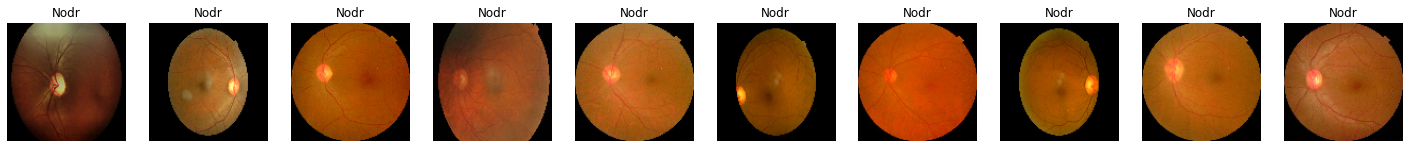

Mild 370 0.2300995024875622


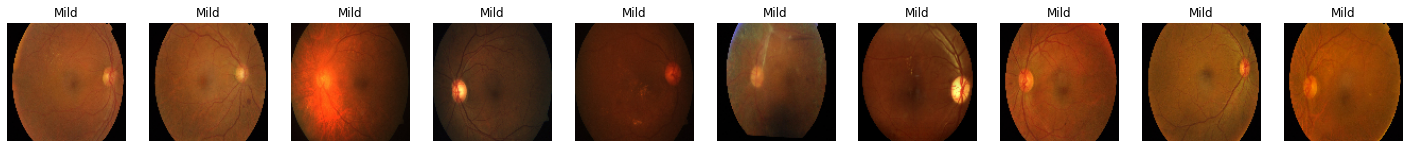

Moderate 296 0.18407960199004975


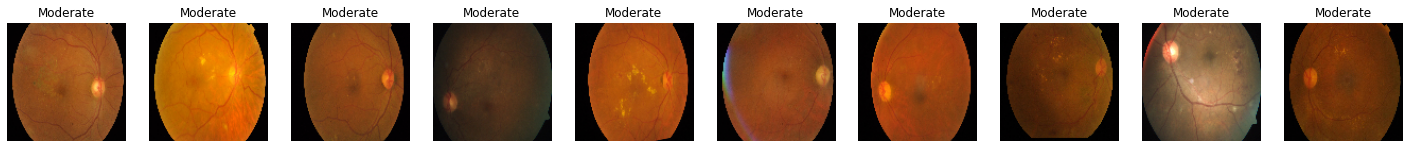

Severe 194 0.12064676616915423


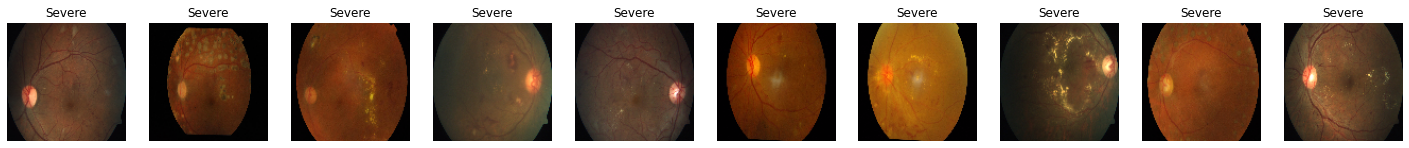

Proliferative 295 0.18345771144278608


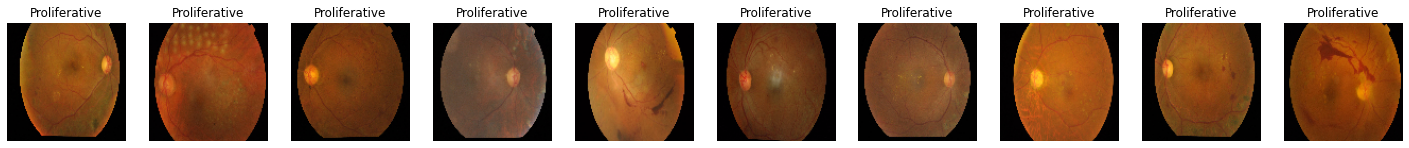

In [5]:
n_total_images = Images.shape[0]

for target_cls in [0, 1, 2, 3, 4]:
    
    indices = np.where(Classes == target_cls)[0] # get target class indices on Images / Classes
    n_target_cls = indices.shape[0]
    label = class_to_label[target_cls]
    print(label, n_target_cls, n_target_cls/n_total_images)

    n_cols = 10 # # of sample plot
    fig, axs = plt.subplots(ncols=n_cols, figsize=(25, 3))

    for i in range(n_cols):

        axs[i].imshow(np.uint8(Images[indices[i]]))
        axs[i].axis('off')
        axs[i].set_title(label)

    plt.show()

In [6]:
indices_train, indices_test = train_test_split(list(range(Images.shape[0])), train_size=0.8, test_size=0.2, shuffle=False)

x_train = Images[indices_train]
y_train = Classes[indices_train]
x_test = Images[indices_test]
y_test = Classes[indices_test]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1286, 112, 112, 3), (1286,), (322, 112, 112, 3), (322,))

In [7]:
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)

y_train.shape, y_test.shape

((1286, 5), (322, 5))

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [9]:
datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
    rotation_range=30,                       # randomly rotate images in the range
    zoom_range=0.1,                          # Randomly zoom image
    width_shift_range=0.1,                   # randomly shift images horizontally
    height_shift_range=0.1,                  # randomly shift images vertically
    horizontal_flip=True,                    # randomly flip images horizontally
    vertical_flip=False,                     # randomly flip images vertically
)
datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
)

In [10]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [11]:
def build_model():
    """build model function"""
    
    # Resnet
    input_tensor = Input(shape=(W, H, 3)) 
    resnet50 = ResNet50(
        include_top=False,                # To change output shape
        weights='imagenet',               # Use pre-trained model
        input_tensor=input_tensor,        # Change input shape for this task
    )
    
    # fc layer
    top_model = Sequential()
    top_model.add(GlobalAveragePooling2D())               # Add GAP for cam
    top_model.add(Dense(n_classes, activation='softmax')) # Change output shape for this task
    
    # model
    model = Model(inputs=resnet50.input, outputs=top_model(resnet50.output))
    
    # frozen weights
    for layer in model.layers[:-10]:
        layer.trainable = False or isinstance(layer, BatchNormalization) # If Batch Normalization layer, it should be trainable
        
    # compile
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [12]:
model = build_model()

2022-04-28 15:01:29.072854: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-28 15:01:29.170942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-28 15:01:29.171809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


94781440/94765736 [==============================] - 1s 0us/step


2022-04-28 15:01:35.269827: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-28 15:01:35.272062: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-28 15:01:35.273559: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-28 15:01:35.274749: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 118, 118, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 56, 56, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 56, 56, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [14]:
history = model.fit_generator(
    datagen_train.flow(x_train, y_train, batch_size=32),
    epochs=10,
    validation_data=datagen_test.flow(x_test, y_test, batch_size=32),
)

Epoch 1/10


2022-04-28 15:01:53.748003: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


41/41 [==============================] - 27s 236ms/step - batch: 20.0000 - size: 31.3659 - loss: 1.4333 - accuracy: 0.4720 - val_loss: 5.1735 - val_accuracy: 0.3416
Epoch 2/10
41/41 [==============================] - 8s 199ms/step - batch: 20.0000 - size: 31.3659 - loss: 1.0543 - accuracy: 0.5848 - val_loss: 1.7048 - val_accuracy: 0.5124
Epoch 3/10
41/41 [==============================] - 7s 176ms/step - batch: 20.0000 - size: 31.3659 - loss: 0.9503 - accuracy: 0.5956 - val_loss: 2.3235 - val_accuracy: 0.4534
Epoch 4/10
41/41 [==============================] - 8s 187ms/step - batch: 20.0000 - size: 31.3659 - loss: 0.8680 - accuracy: 0.6485 - val_loss: 1.6726 - val_accuracy: 0.5373
Epoch 5/10
41/41 [==============================] - 8s 196ms/step - batch: 20.0000 - size: 31.3659 - loss: 0.8610 - accuracy: 0.6625 - val_loss: 1.3980 - val_accuracy: 0.5497
Epoch 6/10
41/41 [==============================] - 8s 208ms/step - batch: 20.0000 - size: 31.3659 - loss: 0.8562 - accuracy: 0.6563 - 

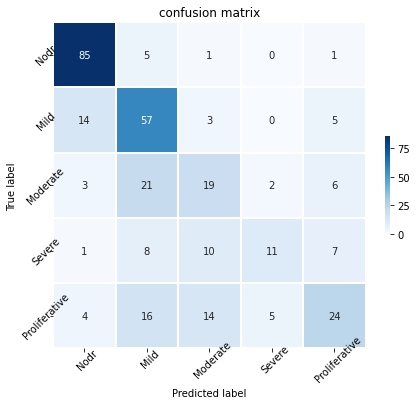

In [15]:
x = preprocess_input(copy.deepcopy(x_test))
y_preds = model.predict(x)
y_preds = np.argmax(y_preds, axis=1)
y_trues = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_trues, y_preds)

fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': .3}, linewidths=.1, ax=ax)

ax.set(
    xticklabels=list(label_to_class.keys()),
    yticklabels=list(label_to_class.keys()),
    title='confusion matrix',
    ylabel='True label',
    xlabel='Predicted label'
)
params = dict(rotation=45, ha='center', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), **params)
plt.setp(ax.get_xticklabels(), **params)
plt.show()

In [16]:
def superimpose(img, cam):
    """superimpose original image and cam heatmap"""
    
    heatmap = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap * .5 + img * .5
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)#convert one color space to another
    
    return img, heatmap, superimposed_img

In [17]:
def _plot(model, cam_func, img, cls_true):
    """plot original image, heatmap from cam and superimpose image"""
    
    # for cam
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(copy.deepcopy(x))

    # for superimpose
    img = np.uint8(img)

    # cam / superimpose
    cls_pred, cam = cam_func(model=model, x=x, layer_name=model.layers[-2].name)
    img, heatmap, superimposed_img = superimpose(img, cam)

    fig, axs = plt.subplots(ncols=3, figsize=(9, 4))

    axs[0].imshow(img)
    axs[0].set_title('original image')
    axs[0].axis('off')

    axs[1].imshow(heatmap)
    axs[1].set_title('heatmap')
    axs[1].axis('off')

    axs[2].imshow(superimposed_img)
    axs[2].set_title('superimposed image')
    axs[2].axis('off')

    plt.suptitle('True label: ' + class_to_label[cls_true] + ' / Predicted label : ' + class_to_label[cls_pred])
    plt.tight_layout()
    plt.show()

In [18]:
def grad_cam(model, x, layer_name):
    """Grad-CAM function"""
    
    cls = np.argmax(model.predict(x))
    
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    # Get outputs and grads
    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([x])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    
    weights = np.mean(grads_val, axis=(0, 1)) # Passing through GlobalAveragePooling

    cam = np.dot(output, weights) # multiply
    cam = np.maximum(cam, 0)      # Passing through ReLU
    cam /= np.max(cam)            # scale 0 to 1.0

    return cls, cam


In [19]:
arr=[]

for target_clss in [4]:
    
    indices = np.where(Classes == target_clss)[0]
    arr=indices;
    print(arr)

[   0    7    9   11   16   35   36   42   46   54   56   59   60   62
   68   75   92   94   96  101  103  104  108  124  134  135  137  142
  143  145  148  151  154  164  165  175  177  187  189  194  196  205
  207  220  228  245  247  249  254  255  257  269  270  273  278  286
  292  300  303  304  311  320  321  325  332  337  341  342  358  366
  370  374  375  396  397  400  403  431  449  451  456  458  459  472
  476  478  479  480  481  487  492  497  507  513  514  522  524  526
  535  536  538  542  547  553  560  572  573  579  596  609  610  614
  616  620  625  633  636  639  645  646  647  648  659  661  665  669
  699  710  714  717  720  734  749  751  752  759  763  767  770  776
  778  783  785  787  797  798  806  807  818  820  828  838  840  842
  849  851  857  860  865  876  878  879  880  889  893  896  916  930
  935  942  951  955  957  959  961  969  974  975  986 1002 1009 1019
 1020 1044 1050 1057 1058 1066 1067 1068 1079 1083 1084 1087 1089 1090
 1100 

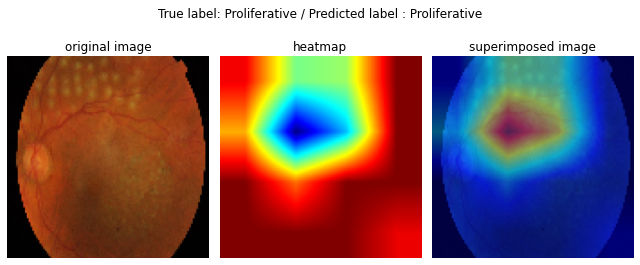

In [20]:


_plot(model=model, cam_func=grad_cam, img=Images[7],cls_true=Classes[7])

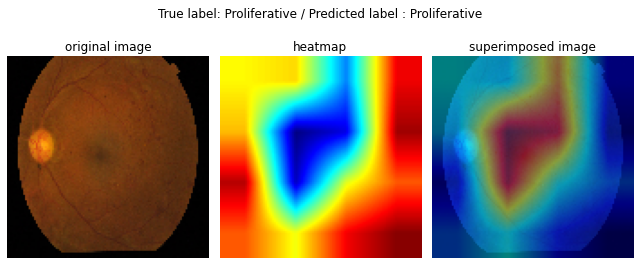

In [21]:
_plot(model=model, cam_func=grad_cam, img=Images[9],cls_true=Classes[9])

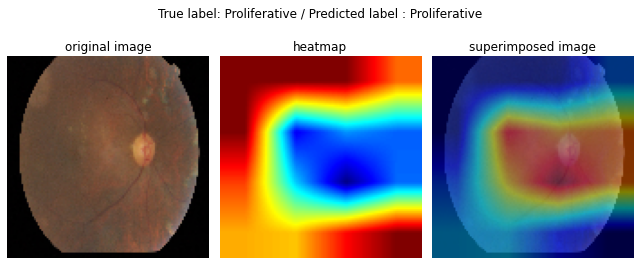

In [22]:
_plot(model=model, cam_func=grad_cam, img=Images[11],cls_true=Classes[11])

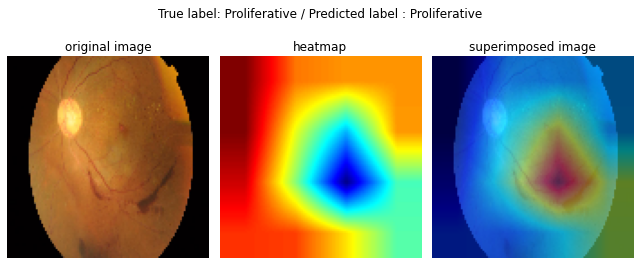

In [23]:
_plot(model=model, cam_func=grad_cam, img=Images[16],cls_true=Classes[16])

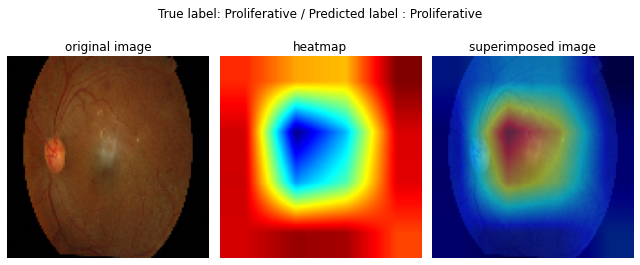

In [24]:
_plot(model=model, cam_func=grad_cam, img=Images[35],cls_true=Classes[35])

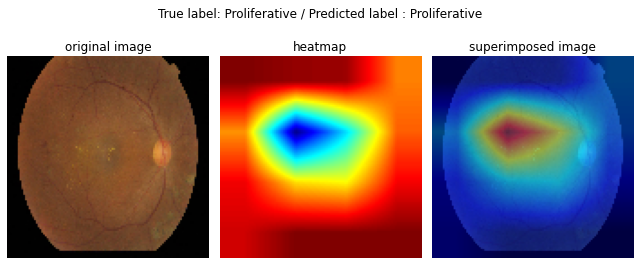

In [25]:
_plot(model=model, cam_func=grad_cam, img=Images[36],cls_true=Classes[36])

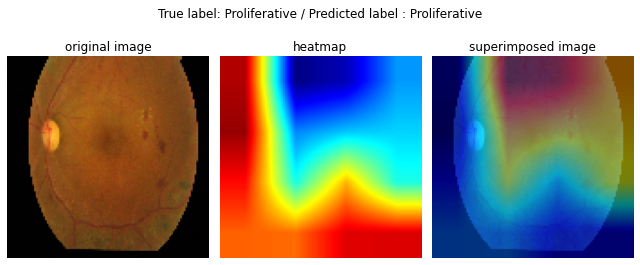

In [26]:
_plot(model=model, cam_func=grad_cam, img=Images[46],cls_true=Classes[46])

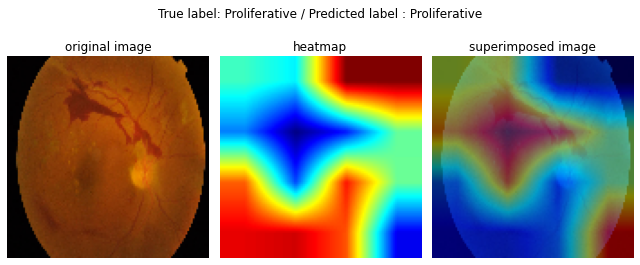

In [27]:
_plot(model=model, cam_func=grad_cam, img=Images[54],cls_true=Classes[54])

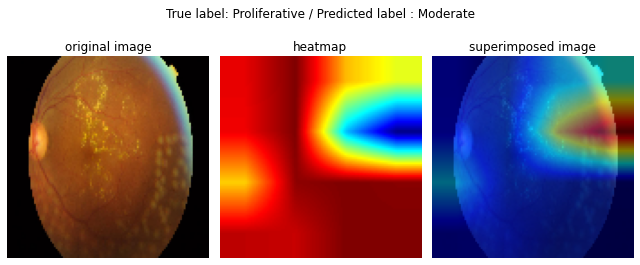

In [28]:
_plot(model=model, cam_func=grad_cam, img=Images[59],cls_true=Classes[59])

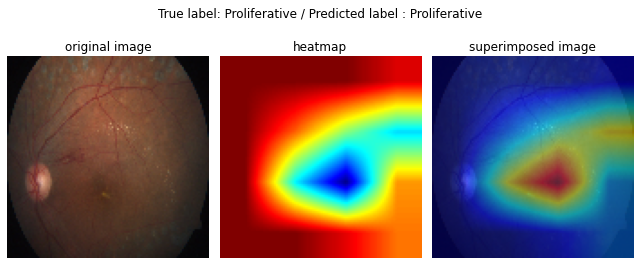

In [29]:
_plot(model=model, cam_func=grad_cam, img=Images[249],cls_true=Classes[249])

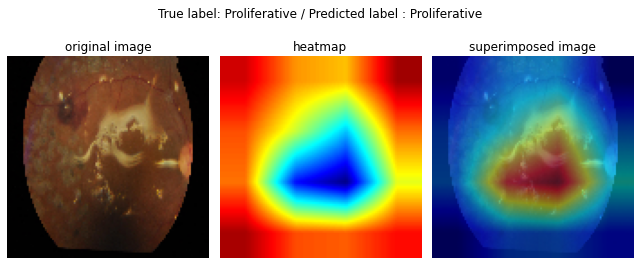

In [30]:
_plot(model=model, cam_func=grad_cam, img=Images[366],cls_true=Classes[366])

In [31]:
def grad_cam_plus_plus(model, x, layer_name):
    """Grad-CAM++ function"""
    
    cls = np.argmax(model.predict(x))
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    first = K.exp(y_c) * grads
    second = K.exp(y_c) * grads * grads
    third = K.exp(y_c) * grads * grads * grads

    gradient_function = K.function([model.input], [y_c, first, second, third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad, conv_third_grad, conv_output, grads_val = gradient_function([x])
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0] * 2.0 + conv_third_grad[0] * global_sum.reshape((1, 1, conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num / alpha_denom # 0


    weights = np.maximum(conv_first_grad[0], 0.0)
    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0), axis=0) # 0
    alphas /= alpha_normalization_constant.reshape((1, 1, conv_first_grad[0].shape[2])) # NAN
    deep_linearization_weights = np.sum((weights * alphas).reshape((-1, conv_first_grad[0].shape[2])), axis=0)

    cam = np.sum(deep_linearization_weights * conv_output[0], axis=2)
    cam = np.maximum(cam, 0) # Passing through ReLU
    cam /= np.max(cam)       # scale 0 to 1.0  

    return cls, cam

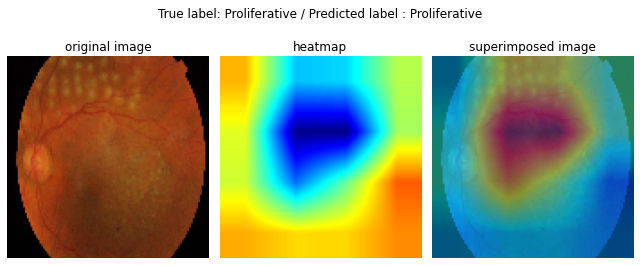

In [32]:
_plot(model=model, cam_func=grad_cam_plus_plus, img=Images[7], cls_true=Classes[7])

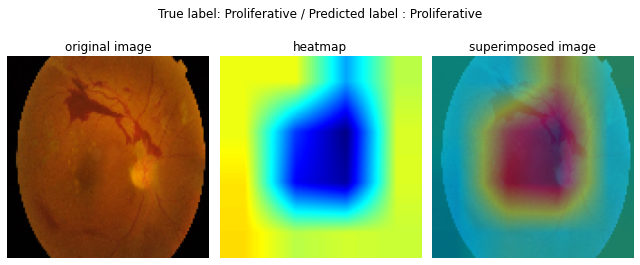

In [33]:
_plot(model=model, cam_func=grad_cam_plus_plus, img=Images[54], cls_true=Classes[54])

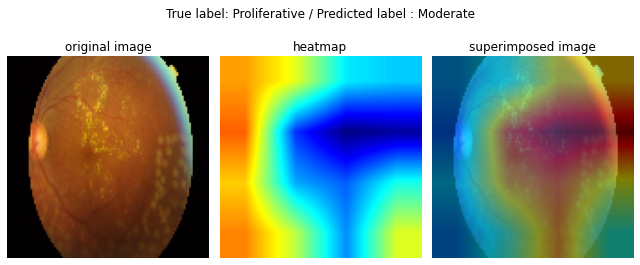

In [34]:
_plot(model=model, cam_func=grad_cam_plus_plus, img=Images[59], cls_true=Classes[59])


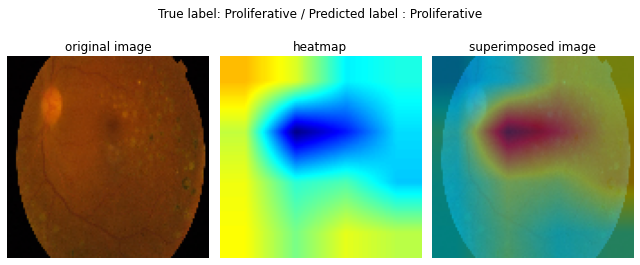

In [35]:
_plot(model=model, cam_func=grad_cam_plus_plus, img=Images[62], cls_true=Classes[62])

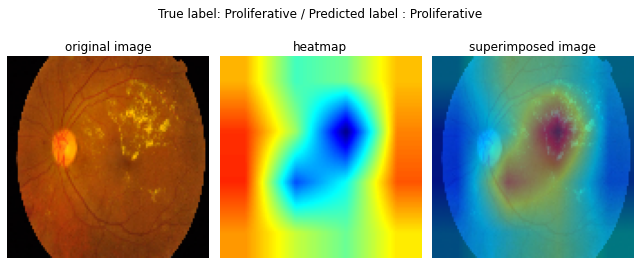

In [36]:
_plot(model=model, cam_func=grad_cam_plus_plus, img=Images[292], cls_true=Classes[292])

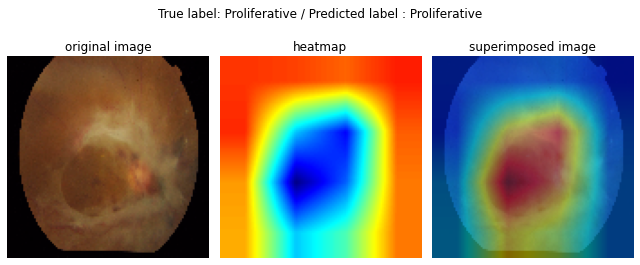

In [37]:
_plot(model=model, cam_func=grad_cam_plus_plus, img=Images[304], cls_true=Classes[304])

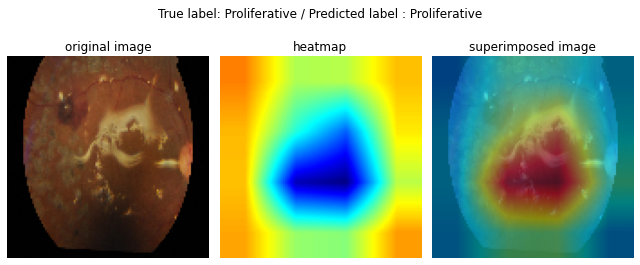

In [38]:
_plot(model=model, cam_func=grad_cam_plus_plus, img=Images[366], cls_true=Classes[366])